In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import statsmodels.api as sm

# Need to move TRANSFORMERS and text_to_code_q6 to other script
from build_model_multinomial import TRANSFORMERS, text_to_code_q6, text_to_code_q10_2_binary, fallback_text_to_float, text_to_code_q10_2_binary_exclude_neither
from build_model_logistic import build_v2g_model_binary_from_df
from get_data import init_column_map, pull_data_rowwise

In [2]:
# Define all variable categories
from variables import (
    demographics, input_variables_vehicle_ownership, familiarity, kms_driven, renewables_at_home,
    parking, q6a_cols, energ_literacy, renewables_at_home, intent_to_purchase_vehicle,
    benefits_v2g, concerns_v2g, interest_in_services, consider_using_NRMA_for,
    charging_control, preference_on_batt_use, expected_return,
    q6a_petrol, q6a_ev, q6a_plughyb, q6a_hybrid,
    feature_label_map
)

# 2. Model Setup

## 2.1. Initialise dataframe

In [3]:
csv_file = './data/survey_pre_processed_data.csv'

In [4]:
target_variable = 'Q10_2'  # "I would be interested in installing V2G..."

In [5]:
q10_2_categories = [
    "Strongly disagree",
    "Somewhat disagree",
    "Neither agree nor disagree",
    "Somewhat agree",
    "Strongly agree"
    ]

In [6]:
# Pull the data from CSV
init_column_map(csv_file)

# TBD -> Make function here
columns_of_interest = (
    familiarity +
    kms_driven + 
    renewables_at_home + 
    q6a_cols + 
    demographics + 
    input_variables_vehicle_ownership + 
    parking + 
    benefits_v2g + 
    concerns_v2g +
    energ_literacy +
    [target_variable]
    )

rows = pull_data_rowwise(columns_of_interest, csv_file)

# Make a DataFrame
df = pd.DataFrame(rows, columns=columns_of_interest)
df

,Q9,Q2,Q8_1,Q8_2,Q8_99,Q6ax1_1,Q6ax1_2,Q6ax1_3,Q6ax2_1,Q6ax2_2,...,Q15_6,Q15_7,Q15_8,Q15_9,Q15_10,Q15_99,Q7_1,Q7_2,Q7_3,Q10_2
0,Somewhat familiar,"Less than 10,000",1,0,0,3,5,5,,,...,1,0,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,Neither agree nor disagree
1,Very familiar,"Less than 10,000",1,1,0,5,5,5,5,5,...,0,0,0,0,0,1,Strongly agree,Strongly agree,Somewhat agree,Strongly agree
2,Not at all familiar,"20,001-50,000",0,0,1,2,1,2,,,...,0,0,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,Strongly disagree
3,Not at all familiar,"Less than 10,000",0,0,1,,,,,,...,0,0,0,0,0,0,Somewhat disagree,Somewhat disagree,Somewhat agree,Somewhat disagree
4,Very familiar,"20,001-50,000",1,1,0,5,5,5,4,4,...,0,1,0,0,0,0,Strongly agree,Strongly agree,Somewhat agree,Somewhat agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,Somewhat familiar,"10,000-20,000",1,1,0,,,,1,3,...,1,1,0,0,0,0,Strongly agree,Strongly agree,Neither agree nor disagree,Strongly agree
1354,Somewhat familiar,"Less than 10,000",0,0,1,5,5,5,,,...,0,0,1,0,1,0,Strongly agree,Somewhat agree,Somewhat agree,Neither agree nor disagree
1355,Very familiar,"10,000-20,000",1,0,0,4,4,5,4,4,...,0,1,0,0,1,0,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,Strongly agree
1356,Very familiar,"10,000-20,000",0,0,1,,,,3,5,...,0,0,0,0,1,0,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,Somewhat agree


## 2.2. Clean data

In [7]:
# Ensure "0 - Weekdays" is converted correctly
for col in q6a_cols:
    df[col] = df[col].replace("0 - Weekdays", 0)  # Convert "0 - Weekdays" to 0
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert all values to numbers

# Debugging: Check unique values in each column
for col in q6a_cols:
    print(f"Unique values in {col}: {df[col].dropna().unique()}")

Unique values in Q6ax1_1: [3. 5. 2. 4. 0. 1.]
Unique values in Q6ax1_2: [5. 1. 3. 2. 4. 0.]
Unique values in Q6ax1_3: [5. 2. 0. 4. 3. 1.]
Unique values in Q6ax2_1: [5. 4. 3. 1. 2. 0.]
Unique values in Q6ax2_2: [5. 4. 3. 2. 0. 1.]
Unique values in Q6ax2_3: [5. 4. 3. 1. 0. 2.]
Unique values in Q6ax3_1: [3. 1. 4. 0. 2. 5.]
Unique values in Q6ax3_2: [5. 4. 2. 3. 1.]
Unique values in Q6ax3_3: [5. 2. 3. 4.]
Unique values in Q6ax4_1: [0. 2. 5. 4. 3. 1.]
Unique values in Q6ax4_2: [5. 2. 3. 0. 4. 1.]
Unique values in Q6ax4_3: [5. 3. 0. 1. 4. 2.]


In [8]:
# Count missing responses for each charging question
missing_counts = (df[q6a_cols] == 0).sum()
# Display summary of non-responses per column
print("Number of responses recorded as 0:")
print(missing_counts)

Number of responses recorded as 0:
Q6ax1_1    118
Q6ax1_2     28
Q6ax1_3     31
Q6ax2_1    102
Q6ax2_2     24
Q6ax2_3     14
Q6ax3_1      4
Q6ax3_2      0
Q6ax3_3      0
Q6ax4_1     12
Q6ax4_2      6
Q6ax4_3      9
dtype: int64


In [9]:
# Checking number of vehicles per type
print(df[q6a_petrol + q6a_ev + q6a_plughyb + q6a_hybrid].notna().sum())

Q6ax1_1    874
Q6ax1_2    874
Q6ax1_3    874
Q6ax2_1    768
Q6ax2_2    768
Q6ax2_3    768
Q6ax3_1     33
Q6ax3_2     33
Q6ax3_3     33
Q6ax4_1    111
Q6ax4_2    111
Q6ax4_3    111
dtype: int64


## 2.3. Update transformers to consider Q10_2 as binary (other than multinomial)

In [10]:
# Make a copy of TRANSFORMERS and update it with Q6a mappings
TRANSFORMERS_q6a = TRANSFORMERS.copy()

In [11]:
# Update with Q6a_* variables (charging behavior questions)
TRANSFORMERS_q6a.update({
    **{q: text_to_code_q6 for q in q6a_petrol},  
    **{q: text_to_code_q6 for q in q6a_ev},      
    **{q: text_to_code_q6 for q in q6a_plughyb}, 
    **{q: text_to_code_q6 for q in q6a_hybrid}   
})

In [12]:
TRANSFORMERS_q6a[target_variable] = text_to_code_q10_2_binary
TRANSFORMERS_q6a

{'Q1_1': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_2': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_3': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_4': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_99': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q2': <function build_model_multinomial.text_to_code_q2(raw_ans)>,
 'Q3_1': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_2': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_3': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_4': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_5': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q7_1': <function build_model_multinomial.text_to_code_q7_likert(raw_ans)>,
 'Q7_2': <function build_model_multinomial.text_to_code_q7_likert(raw_ans)>,
 'Q7_3': <functio

# 3. Feature Selection - Univariate Logistic Regression Analysis

## 3.1. Full dataset

In [13]:
features_to_select = (
    familiarity + 
    kms_driven +
    renewables_at_home +
    input_variables_vehicle_ownership + 
    q6a_petrol + 
    q6a_ev + 
    q6a_hybrid +
    q6a_plughyb +
    parking +
    benefits_v2g + 
    concerns_v2g + 
    energ_literacy
)

In [14]:
df[target_variable] = df[target_variable].apply(text_to_code_q10_2_binary)

# Ensure the target variable is binary (0 or 1)
df[target_variable] = df[target_variable].astype(int)

## 3.2. Vehicle at home habits

In [15]:
missing_q6a = df[q6a_cols].isna().sum()
print("Missing values per Q6a variable:\n", missing_q6a)

Missing values per Q6a variable:
 Q6ax1_1     484
Q6ax1_2     484
Q6ax1_3     484
Q6ax2_1     590
Q6ax2_2     590
Q6ax2_3     590
Q6ax3_1    1325
Q6ax3_2    1325
Q6ax3_3    1325
Q6ax4_1    1247
Q6ax4_2    1247
Q6ax4_3    1247
dtype: int64


In [16]:
df[q6a_cols] = df[q6a_cols].fillna(0)

In [17]:
for col in q6a_cols:
    print(f"Unique values in {col}: {df[col].dropna().unique()}")

Unique values in Q6ax1_1: [3. 5. 2. 0. 4. 1.]
Unique values in Q6ax1_2: [5. 1. 0. 3. 2. 4.]
Unique values in Q6ax1_3: [5. 2. 0. 4. 3. 1.]
Unique values in Q6ax2_1: [0. 5. 4. 3. 1. 2.]
Unique values in Q6ax2_2: [0. 5. 4. 3. 2. 1.]
Unique values in Q6ax2_3: [0. 5. 4. 3. 1. 2.]
Unique values in Q6ax3_1: [0. 3. 1. 4. 2. 5.]
Unique values in Q6ax3_2: [0. 5. 4. 2. 3. 1.]
Unique values in Q6ax3_3: [0. 5. 2. 3. 4.]
Unique values in Q6ax4_1: [0. 2. 5. 4. 3. 1.]
Unique values in Q6ax4_2: [0. 5. 2. 3. 4. 1.]
Unique values in Q6ax4_3: [0. 5. 3. 1. 4. 2.]


In [18]:
q6a_filters = {
    "petrol": (df["Q1_1"].astype(int) == 1),
    "ev": (df["Q1_2"].astype(int) == 1),
    "plug_hybrid": (df["Q1_3"].astype(int) == 1),
    "hybrid": (df["Q1_4"].astype(int) == 1),
}

In [19]:
# Initialize list to store results
results = []

# Loop through each feature in features_to_select
for feature in features_to_select:
    print(f"Running Logistic Regression for: {feature}")

    # Ensure the feature exists in the dataframe
    if feature not in df.columns:
        print(f"Skipping {feature} (not in dataframe)")
        continue

    # Apply appropriate filters based on the type of vehicle
    if feature in q6a_petrol:
        filtered_df = df[q6a_filters["petrol"]]
    elif feature in q6a_ev:
        filtered_df = df[q6a_filters["ev"]]
    elif feature in q6a_plughyb:
        filtered_df = df[q6a_filters["plug_hybrid"]]
    elif feature in q6a_hybrid:
        filtered_df = df[q6a_filters["hybrid"]]
    else:
        filtered_df = df  # Default (includes all data)

    # Ensure enough data is available for analysis
    if filtered_df.shape[0] < 10:  # Skip if too few respondents
        print(f"Skipping {feature} (too few valid rows: {filtered_df.shape[0]})")
        continue

    # Convert feature using transformer if available, otherwise cast to numeric
    if feature in TRANSFORMERS_q6a:
        X_single = filtered_df[feature].apply(TRANSFORMERS_q6a[feature])
    else:
        X_single = pd.to_numeric(filtered_df[feature], errors="coerce")  # Convert safely

    # Drop NaN values
    valid_rows = ~X_single.isna()

    print(f"Valid rows are {valid_rows.count()}")
    
    X_single = X_single[valid_rows].values.reshape(-1, 1)
    y = filtered_df.loc[valid_rows, target_variable].values  # Ensure target aligns with valid rows

    # Check if feature has only one unique value
    if len(np.unique(X_single)) == 1:
        print(f"Skipping {feature} (constant value: {np.unique(X_single)[0]})")
        continue

    # Fit logistic regression
    model = LogisticRegression(penalty='l1', solver='liblinear')
    model.fit(X_single, y)

    # Predict & evaluate performance
    y_pred = model.predict(X_single)
    accuracy = accuracy_score(y, y_pred)

    # Get coefficient & odds ratio
    coef = model.coef_[0][0]
    odds_ratio = np.exp(coef)

    # Fit logistic regression using statsmodels for p-value
    X_with_intercept = sm.add_constant(X_single)
    sm_model = sm.Logit(y, X_with_intercept).fit(disp=0)  # Suppress verbose output
    p_value = sm_model.pvalues[1]  # Extract p-value for feature

    # Store results
    results.append({
        "Feature": feature_label_map.get(feature, feature),  # Use full label if available
        "Accuracy": accuracy,
        "Coefficient": coef,
        "Odds Ratio": odds_ratio,
        "P-value": p_value
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by strongest effect (absolute coefficient)
results_df["abs_coef"] = results_df["Coefficient"].abs()
results_df = results_df.sort_values(by="abs_coef", ascending=False)

Running Logistic Regression for: Q9
Valid rows are 1358
Running Logistic Regression for: Q2
Valid rows are 1358
Running Logistic Regression for: Q8_1
Valid rows are 1358
Running Logistic Regression for: Q8_2
Valid rows are 1358
Running Logistic Regression for: Q8_99
Valid rows are 1358
Running Logistic Regression for: Q1_1
Valid rows are 1358
Running Logistic Regression for: Q1_2
Valid rows are 1358
Running Logistic Regression for: Q1_3
Valid rows are 1358
Running Logistic Regression for: Q1_4
Valid rows are 1358
Running Logistic Regression for: Q1_99
Valid rows are 1358
Running Logistic Regression for: Q6ax1_1
Valid rows are 874
Running Logistic Regression for: Q6ax1_2
Valid rows are 874
Running Logistic Regression for: Q6ax1_3
Valid rows are 874
Running Logistic Regression for: Q6ax2_1
Valid rows are 768
Running Logistic Regression for: Q6ax2_2
Valid rows are 768
Running Logistic Regression for: Q6ax2_3
Valid rows are 768
Running Logistic Regression for: Q6ax4_1
Valid rows are 111
Ru

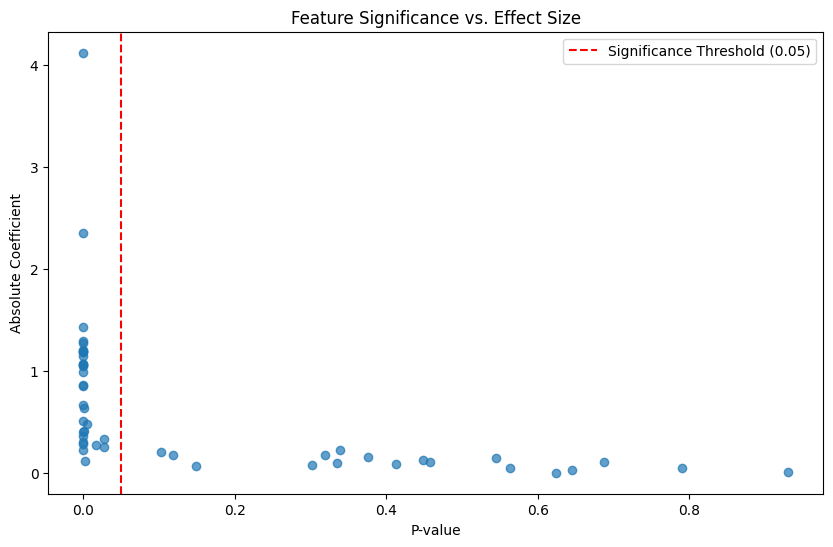

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(results_df["P-value"], results_df["abs_coef"], alpha=0.7)
plt.axvline(x=0.05, color="red", linestyle="--", label="Significance Threshold (0.05)")
plt.xlabel("P-value")
plt.ylabel("Absolute Coefficient")
plt.title("Feature Significance vs. Effect Size")
plt.legend()
plt.show()

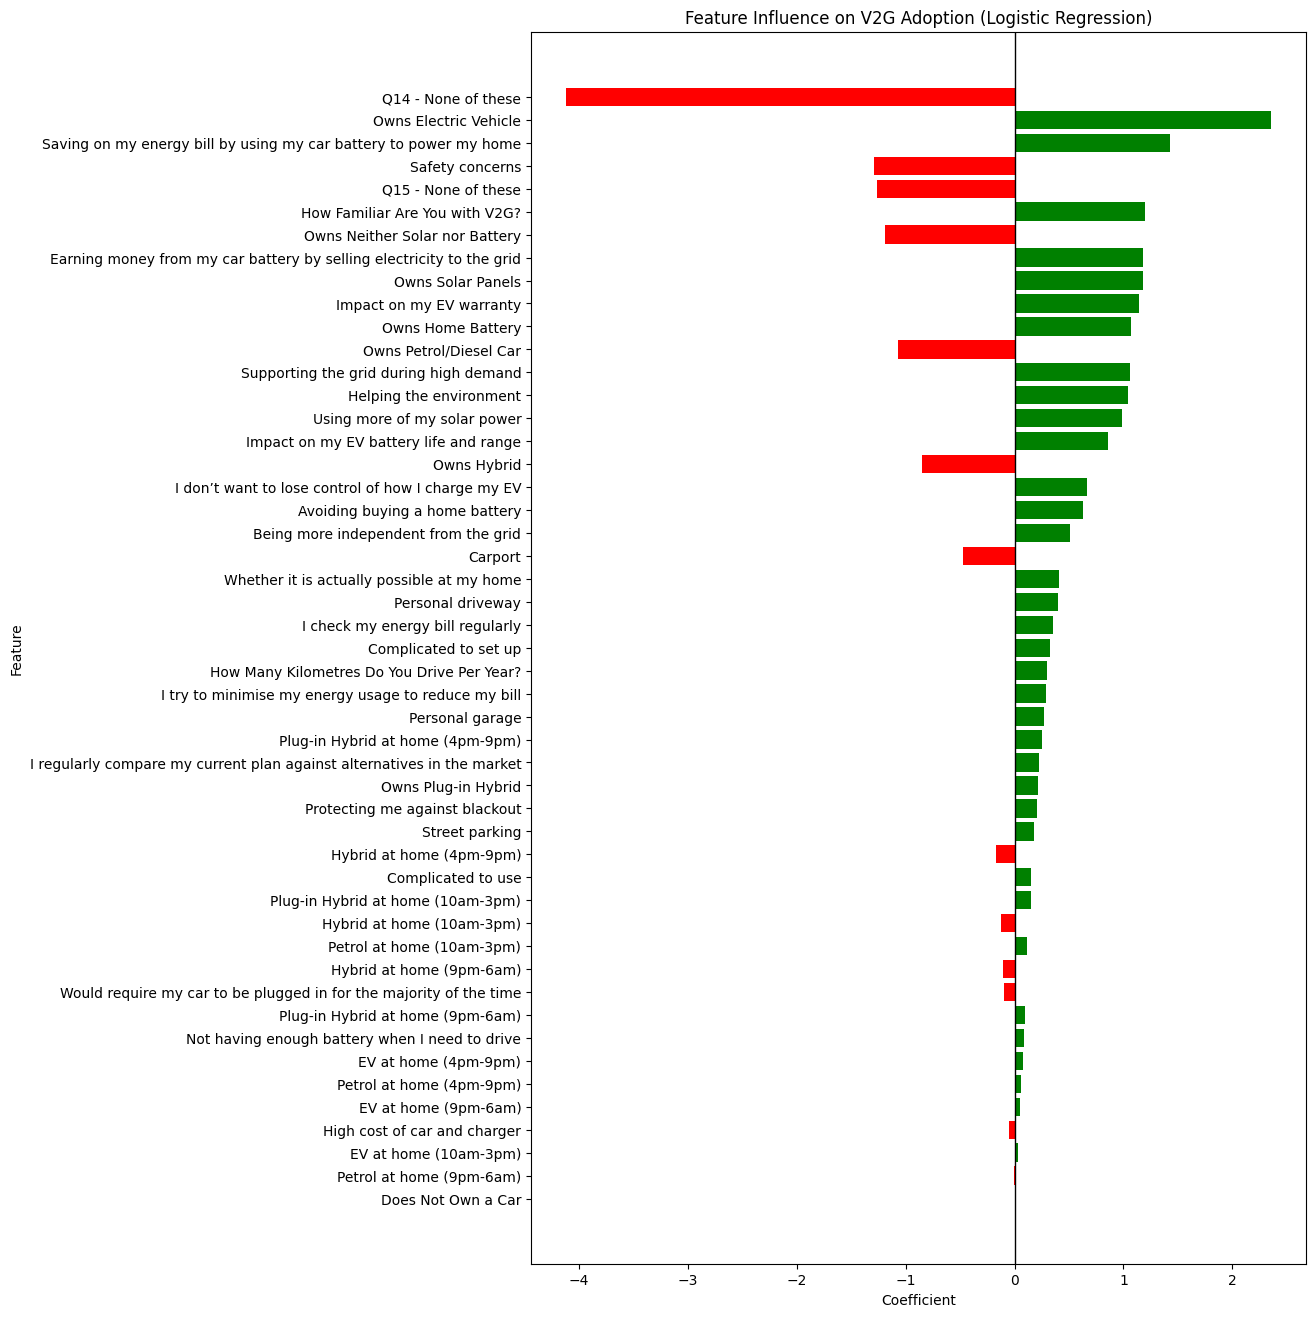

In [21]:
import matplotlib.pyplot as plt

# Sort by absolute coefficient value
results_df_sorted = results_df.sort_values(by="abs_coef", ascending=True)

# Plot
plt.figure(figsize=(10, 16))
plt.barh(results_df_sorted["Feature"], results_df_sorted["Coefficient"], color=["green" if x > 0 else "red" for x in results_df_sorted["Coefficient"]])
plt.axvline(0, color="black", linewidth=1)  # Add a vertical line at 0 for reference
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Feature Influence on V2G Adoption (Logistic Regression)")
plt.show()


In [22]:
results_df_sorted

,Feature,Accuracy,Coefficient,Odds Ratio,P-value,abs_coef
9,Does Not Own a Car,0.523564,0.000000,1.000000,6.244949e-01,0.000000
12,Petrol at home (9pm-6am),0.569794,-0.007800,0.992230,9.303656e-01,0.007800
13,EV at home (10am-3pm),0.755208,0.027872,1.028264,6.457641e-01,0.027872
35,High cost of car and charger,0.523564,-0.047331,0.953771,5.636215e-01,0.047331
15,EV at home (9pm-6am),0.755208,0.049476,1.050721,7.907342e-01,0.049476
11,Petrol at home (4pm-9pm),0.569794,0.061817,1.063767,1.489488e-01,0.061817
14,EV at home (4pm-9pm),0.755208,0.077293,1.080358,3.014971e-01,0.077293
40,Not having enough battery when I need to drive,0.523564,0.085850,1.089643,4.132340e-01,0.085850
21,Plug-in Hybrid at home (9pm-6am),0.606061,0.097558,1.102475,3.351730e-01,0.097558
43,Would require my car to be plugged in for the ...,0.523564,-0.100726,0.904181,4.575738e-01,0.100726


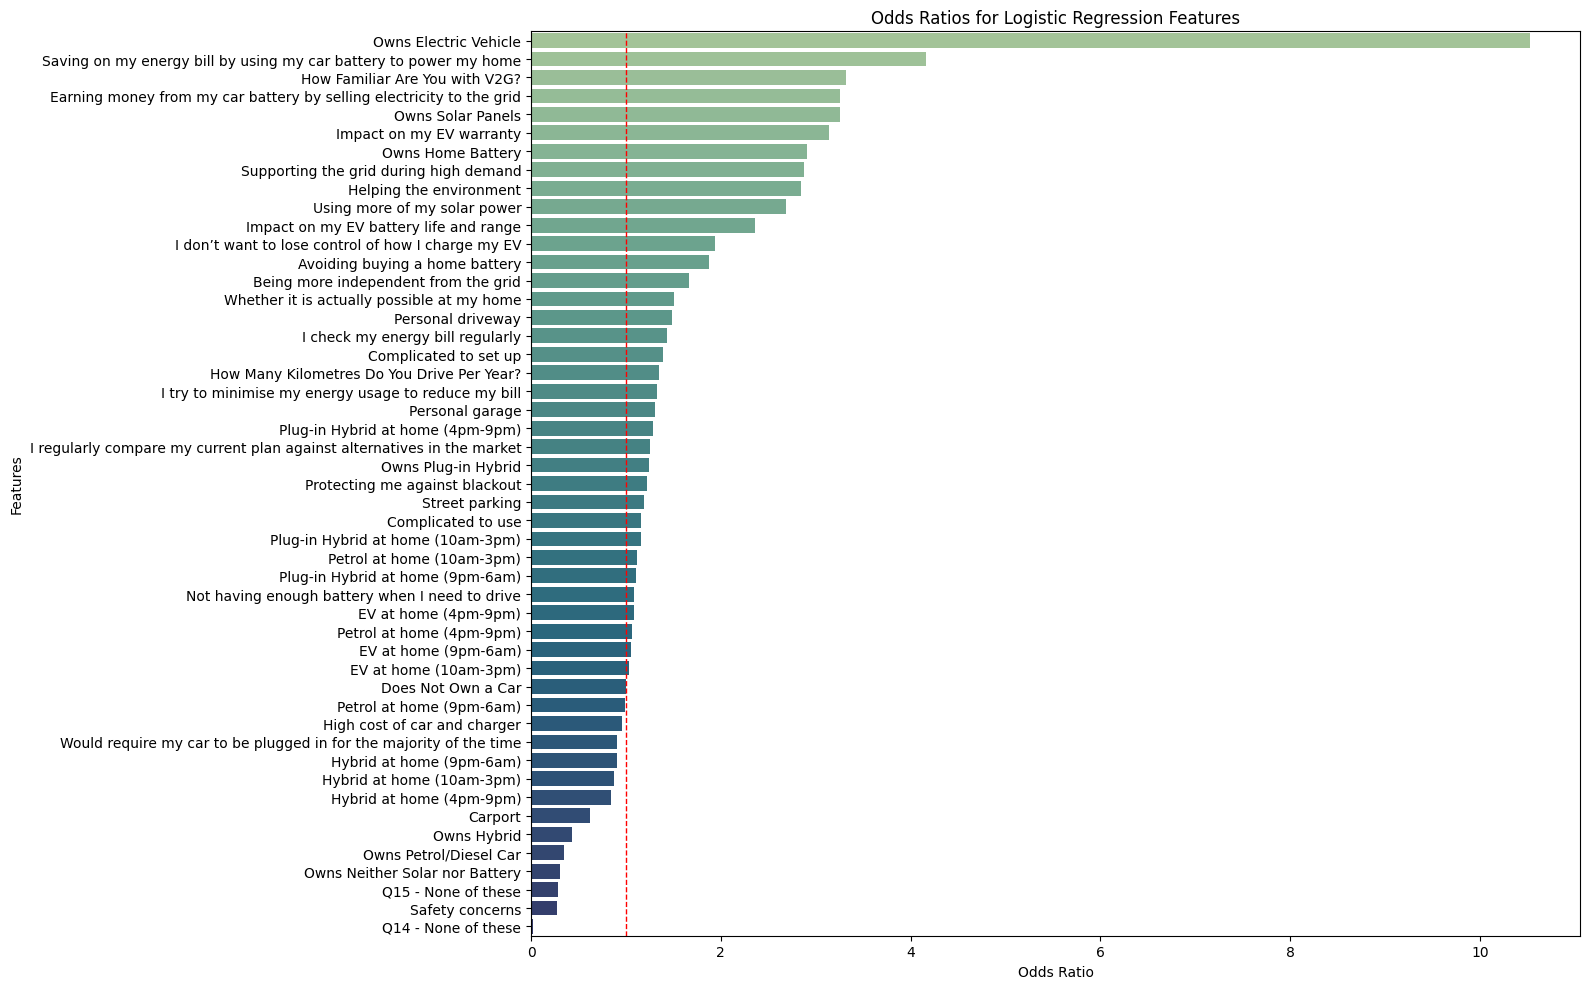

In [23]:
# Sort by odds ratio
results_df_sorted = results_df.sort_values(by="Odds Ratio", ascending=False)

# Create a figure
plt.figure(figsize=(16, 10))

# Plot a horizontal bar chart of odds ratios
sns.barplot(
    data=results_df_sorted, 
    x='Odds Ratio', 
    y='Feature', 
    orient='h',  # horizontal bars
    palette='crest'  # single color for all bars
)

# Add a vertical reference line at x=1 (odds ratio = 1 implies no effect)
plt.axvline(x=1, color='red', linestyle='--', linewidth=1)

# Improve labels/titles
plt.xlabel('Odds Ratio')
plt.ylabel('Features')
plt.title('Odds Ratios for Logistic Regression Features')

# Display the plot
plt.tight_layout()
plt.show()

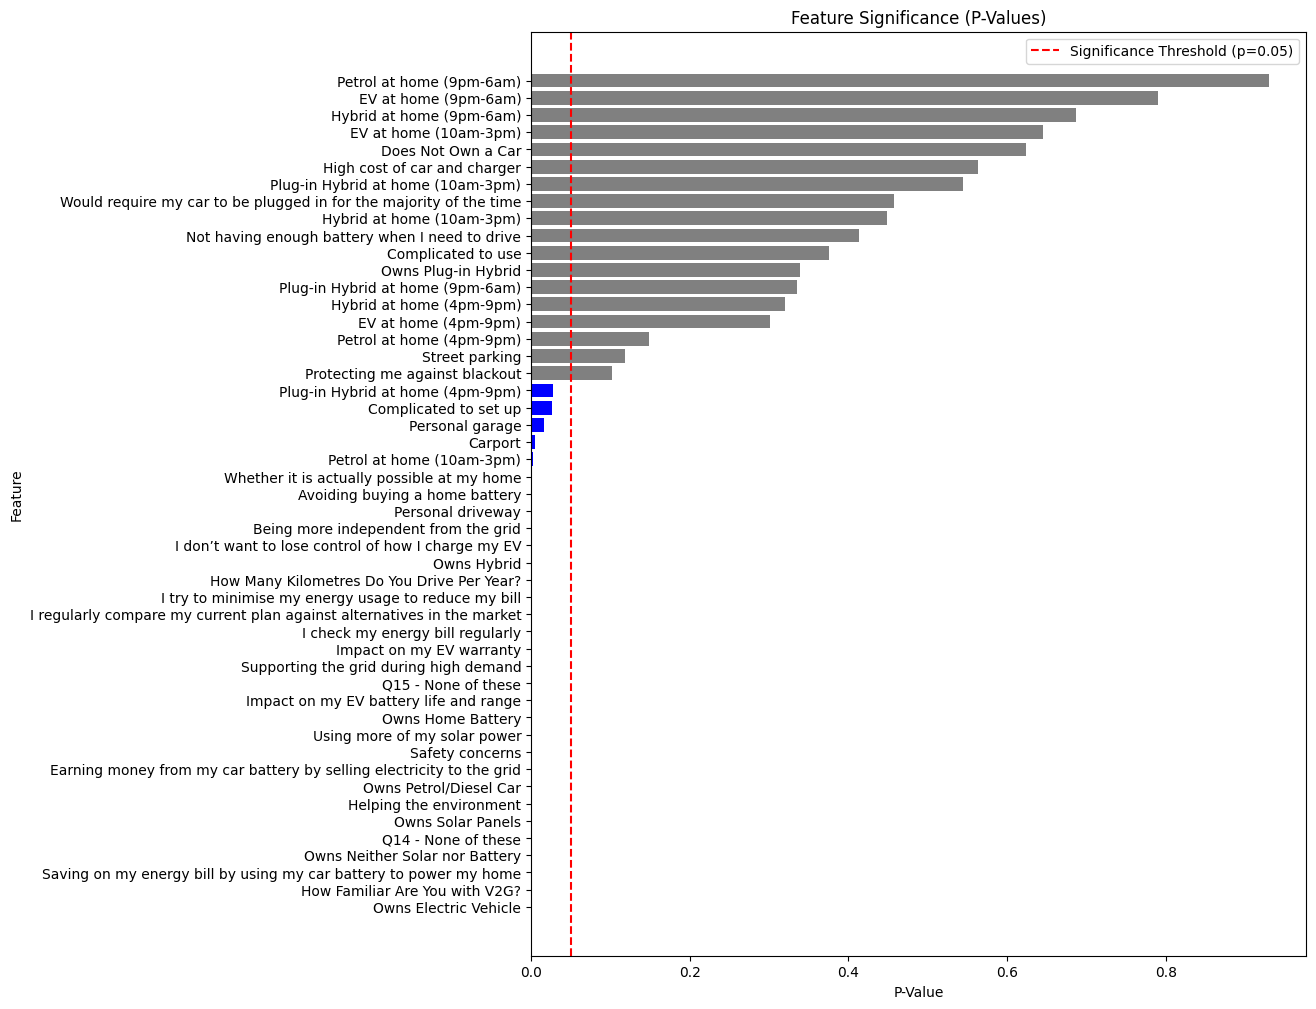

In [24]:
import matplotlib.pyplot as plt

# Sort by p-value
results_df_sorted = results_df.sort_values(by="P-value", ascending=True)

# Plot
plt.figure(figsize=(10, 12))
plt.barh(results_df_sorted["Feature"], results_df_sorted["P-value"], color=["blue" if p < 0.05 else "gray" for p in results_df_sorted["P-value"]])
plt.axvline(0.05, color="red", linestyle="dashed", linewidth=1.5, label="Significance Threshold (p=0.05)")
plt.xlabel("P-Value")
plt.ylabel("Feature")
plt.title("Feature Significance (P-Values)")
plt.legend()
plt.show()


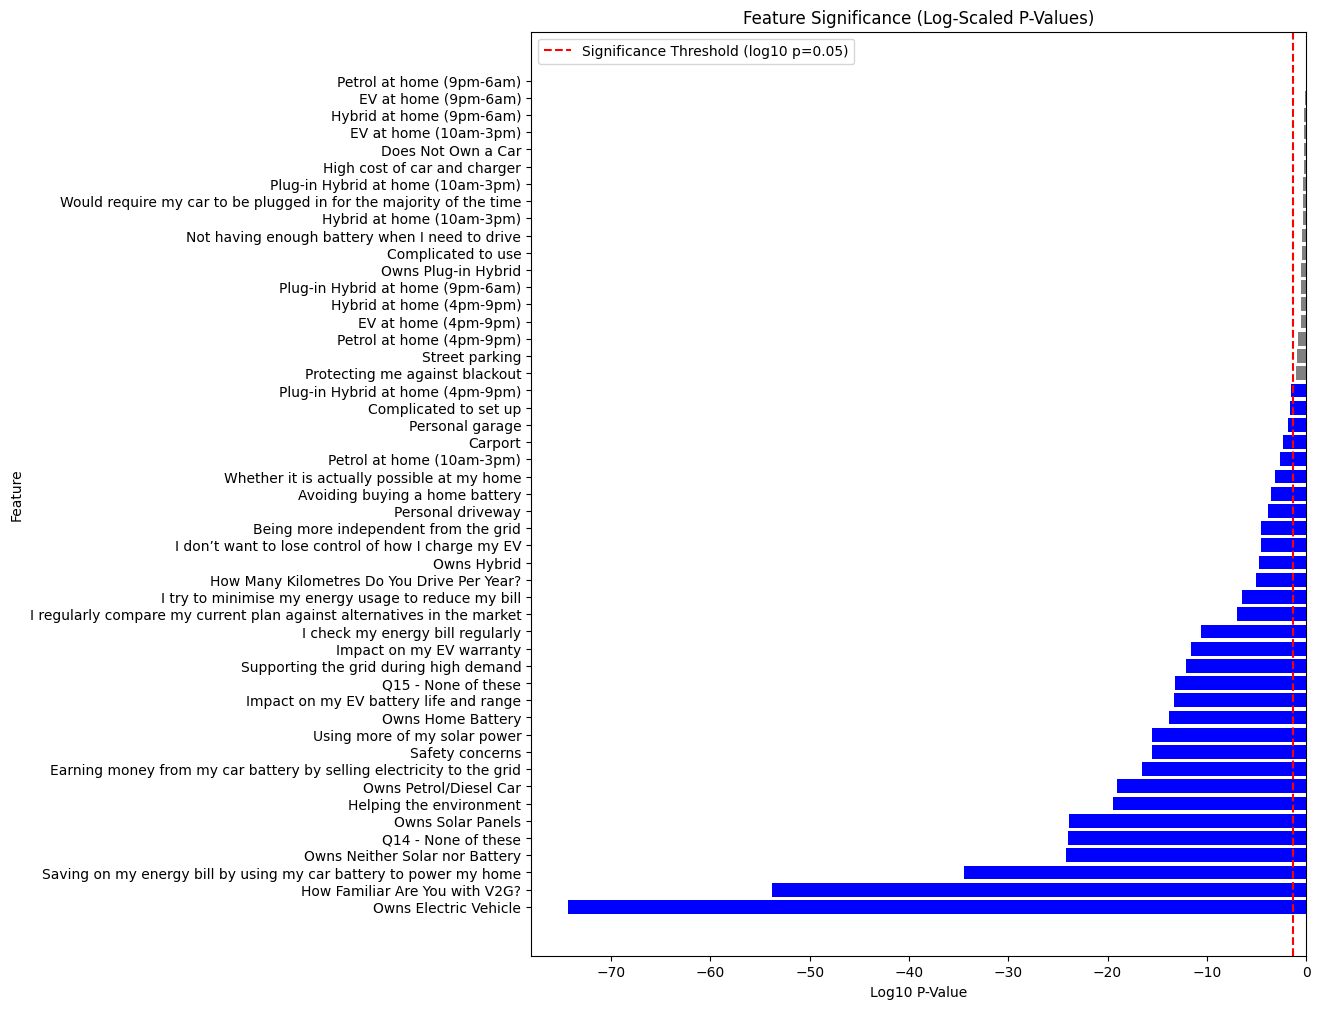

In [25]:
plt.figure(figsize=(10, 12))
plt.barh(results_df_sorted["Feature"], np.log10(results_df_sorted["P-value"]), color=["blue" if p < 0.05 else "gray" for p in results_df_sorted["P-value"]])
plt.axvline(np.log10(0.05), color="red", linestyle="dashed", linewidth=1.5, label="Significance Threshold (log10 p=0.05)")
plt.xlabel("Log10 P-Value")
plt.ylabel("Feature")
plt.title("Feature Significance (Log-Scaled P-Values)")
plt.legend()
plt.show()

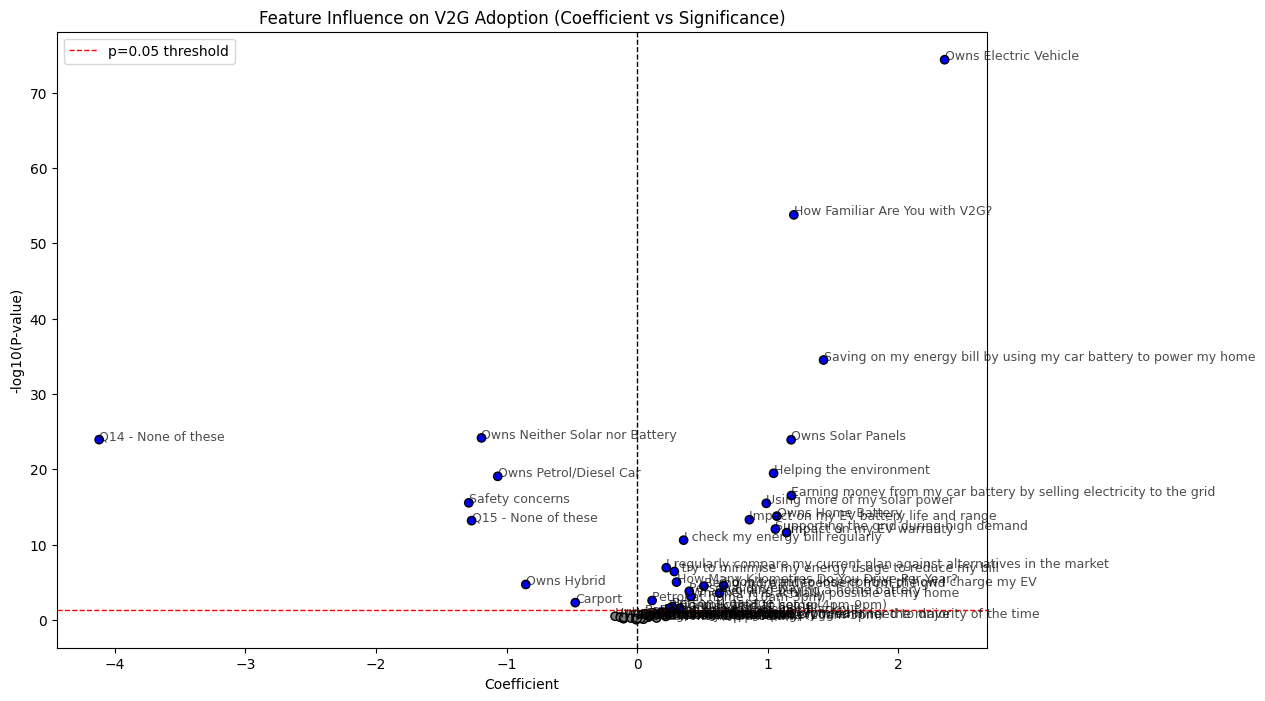

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Compute -log(p-value) for better visualization
results_df["-log(p)"] = -np.log10(results_df["P-value"])

# Define colors based on significance threshold (p < 0.05)
colors = ["blue" if p < 0.05 else "gray" for p in results_df["P-value"]]

# Create scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(results_df["Coefficient"], results_df["-log(p)"], c=colors, edgecolors="black")

# Add labels for key points
for i, txt in enumerate(results_df["Feature"]):
    plt.annotate(txt, (results_df["Coefficient"].iloc[i], results_df["-log(p)"].iloc[i]), fontsize=9, alpha=0.7)

# Reference lines
plt.axvline(0, color="black", linestyle="--", linewidth=1)  # Vertical line at zero coefficient
plt.axhline(-np.log10(0.05), color="red", linestyle="--", linewidth=1, label="p=0.05 threshold")  # Horizontal line at p=0.05

# Labels & title
plt.xlabel("Coefficient")
plt.ylabel("-log10(P-value)")
plt.title("Feature Influence on V2G Adoption (Coefficient vs Significance)")
plt.legend()
plt.show()


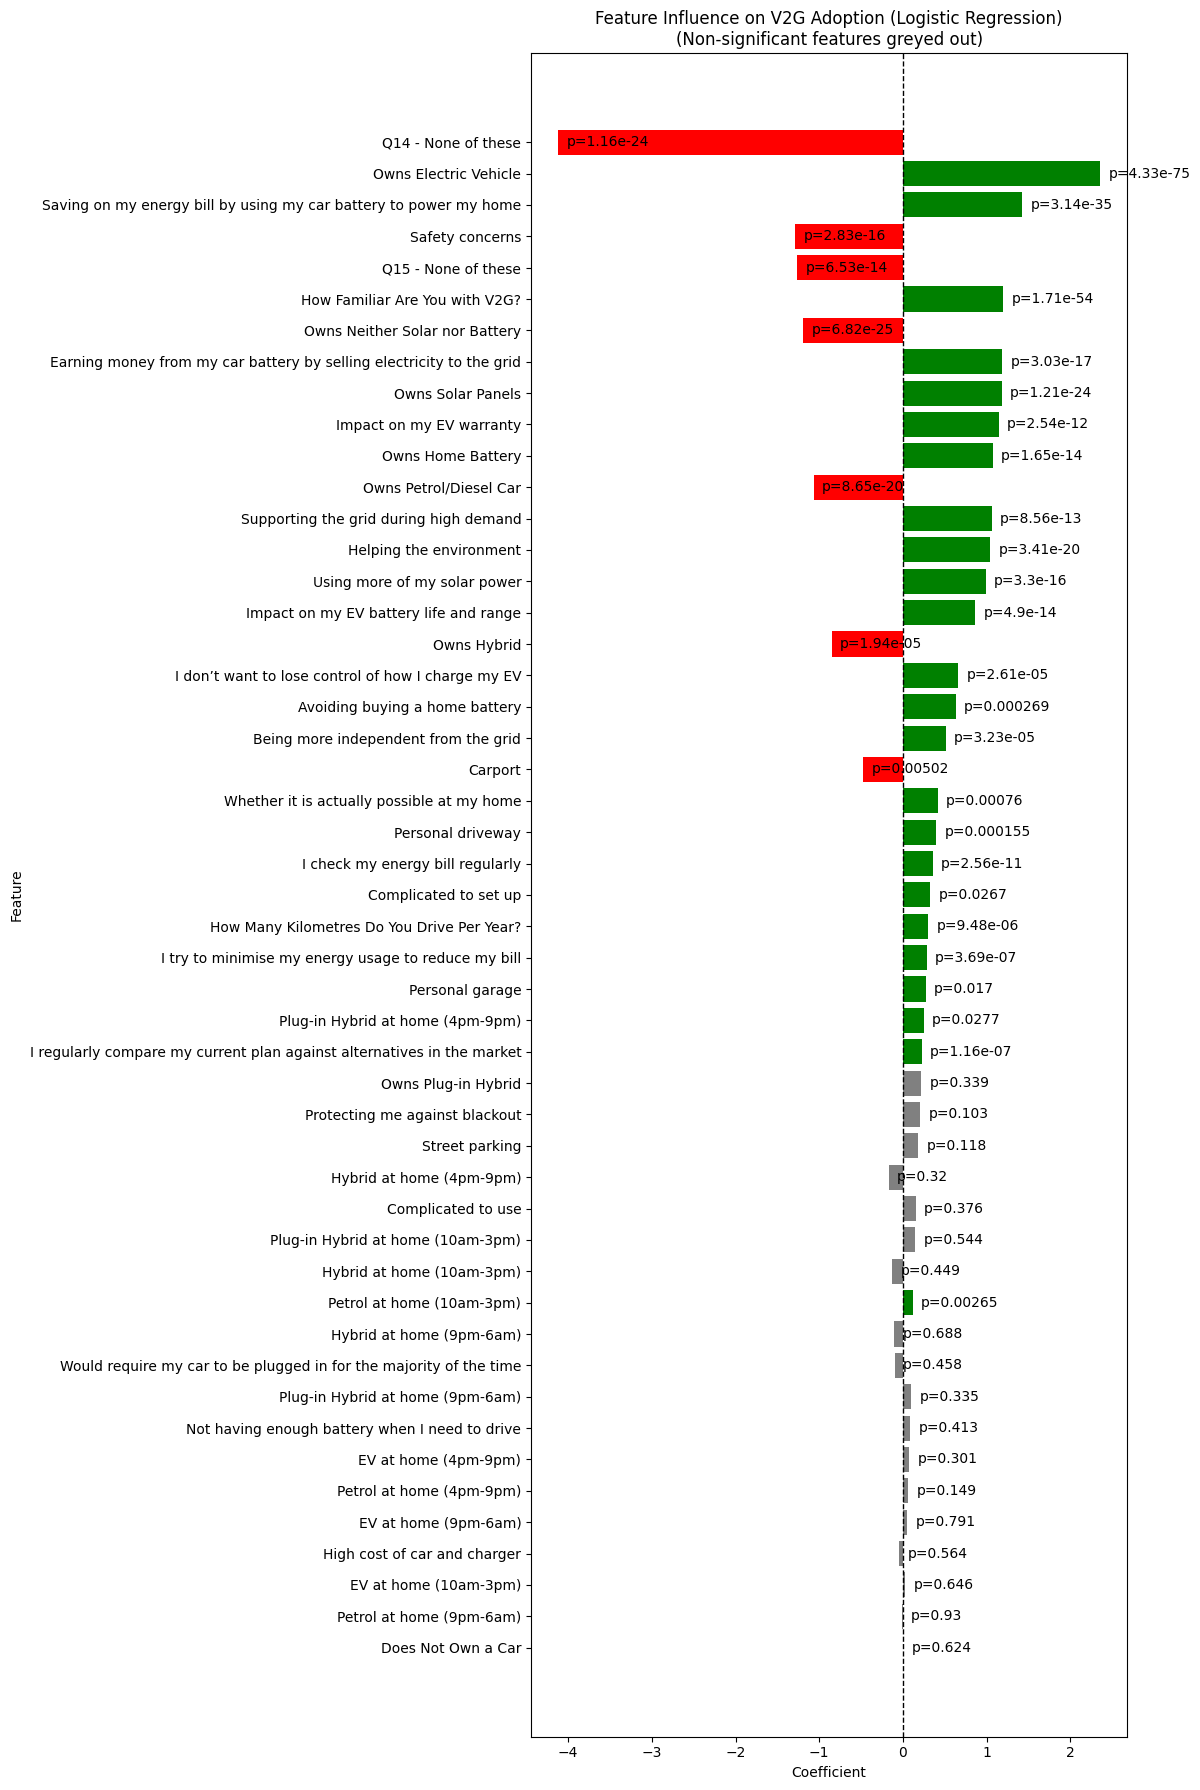

In [27]:
import matplotlib.pyplot as plt

# Sort by absolute coefficient value
results_df_sorted = results_df.sort_values(by="abs_coef", ascending=True)

# Define colors: Gray for p >= 0.05, Green for positive, Red for negative
colors = [
    "gray" if p >= 0.05 else ("green" if coef > 0 else "red")
    for p, coef in zip(results_df_sorted["P-value"], results_df_sorted["Coefficient"])
]

# Create figure
plt.figure(figsize=(12, 18))
bars = plt.barh(results_df_sorted["Feature"], results_df_sorted["Coefficient"], color=colors)

# Add p-value annotations on the right side
for bar, p_value in zip(bars, results_df_sorted["P-value"]):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f"p={p_value:.3g}", va='center', fontsize=10)

# Reference line at zero
plt.axvline(0, color="black", linewidth=1, linestyle="--")

# Labels and title
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Feature Influence on V2G Adoption (Logistic Regression)\n(Non-significant features greyed out)")
plt.tight_layout()  # Adjust layout to prevent text cutoff

# Show the plot
plt.show()


# 4. Binomial Logistic Regression

## 4.1. Filtering my df based on the previous p-value analysis

In [28]:
# Get the list of significant features (p < 0.05)
significant_features = results_df[results_df["P-value"] < 0.05]["Feature"].tolist()

# Map back to original column names using feature_label_map
significant_columns = [key for key, value in feature_label_map.items() if value in significant_features]

# Ensure the target variable is retained
significant_columns.append(target_variable)

# Create a new filtered list for columns_of_interest
columns_of_interest_filtered = [
    col for col in columns_of_interest if col in significant_columns
]

# Display before and after
print(f"Original columns count: {len(columns_of_interest)}")
print(f"Filtered columns count: {len(columns_of_interest_filtered)}")

Original columns count: 59
Filtered columns count: 32


In [29]:
filtered_df = df[columns_of_interest_filtered]

In [30]:
filtered_df

,Q9,Q2,Q8_1,Q8_2,Q8_99,Q6ax1_1,Q6ax3_2,Q1_1,Q1_2,Q1_4,...,Q15_3,Q15_5,Q15_7,Q15_8,Q15_10,Q15_99,Q7_1,Q7_2,Q7_3,Q10_2
0,Somewhat familiar,"Less than 10,000",1,0,0,3.0,0.0,1,0,0,...,0,1,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,0
1,Very familiar,"Less than 10,000",1,1,0,5.0,0.0,1,1,0,...,0,0,0,0,0,1,Strongly agree,Strongly agree,Somewhat agree,1
2,Not at all familiar,"20,001-50,000",0,0,1,2.0,0.0,1,0,0,...,0,0,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,0
3,Not at all familiar,"Less than 10,000",0,0,1,0.0,0.0,0,0,1,...,0,1,0,0,0,0,Somewhat disagree,Somewhat disagree,Somewhat agree,0
4,Very familiar,"20,001-50,000",1,1,0,5.0,0.0,1,1,1,...,0,1,1,0,0,0,Strongly agree,Strongly agree,Somewhat agree,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,Somewhat familiar,"10,000-20,000",1,1,0,0.0,0.0,0,1,0,...,0,1,1,0,0,0,Strongly agree,Strongly agree,Neither agree nor disagree,1
1354,Somewhat familiar,"Less than 10,000",0,0,1,5.0,0.0,1,0,0,...,0,0,0,1,1,0,Strongly agree,Somewhat agree,Somewhat agree,0
1355,Very familiar,"10,000-20,000",1,0,0,4.0,0.0,1,1,0,...,0,1,1,0,1,0,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,1
1356,Very familiar,"10,000-20,000",0,0,1,0.0,0.0,0,1,0,...,0,0,0,0,1,0,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,1


## 4.2. Running regression

In [31]:
filtered_df['Q6ax1_1'] = filtered_df['Q6ax1_1'].fillna(0)
filtered_df['Q6ax3_2'] = filtered_df['Q6ax3_2'].fillna(0)

C:\Users\24417507\AppData\Local\Temp\ipykernel_552\3615609723.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Q6ax1_1'] = filtered_df['Q6ax1_1'].fillna(0)
C:\Users\24417507\AppData\Local\Temp\ipykernel_552\3615609723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Q6ax3_2'] = filtered_df['Q6ax3_2'].fillna(0)


In [32]:
print("Checking if any feature column is missing data...")
print(filtered_df.isnull().sum())

print("\nChecking unique values in target variable (Q10_2):")
print(filtered_df[target_variable].unique())

print("\nChecking number of non-missing rows in dataset:")
valid_rows = filtered_df.dropna().shape[0]
print(f"Valid rows: {valid_rows} / {df.shape[0]}")


Checking if any feature column is missing data...
Q9         0
Q2         0
Q8_1       0
Q8_2       0
Q8_99      0
Q6ax1_1    0
Q6ax3_2    0
Q1_1       0
Q1_2       0
Q1_4       0
Q3_1       0
Q3_2       0
Q3_3       0
Q14_1      0
Q14_2      0
Q14_3      0
Q14_4      0
Q14_5      0
Q14_6      0
Q14_8      0
Q14_99     0
Q15_2      0
Q15_3      0
Q15_5      0
Q15_7      0
Q15_8      0
Q15_10     0
Q15_99     0
Q7_1       0
Q7_2       0
Q7_3       0
Q10_2      0
dtype: int64

Checking unique values in target variable (Q10_2):
[0 1]

Checking number of non-missing rows in dataset:
Valid rows: 1358 / 1358


In [33]:
# Let's confirm all columns in columns_of_interest_filtered have a transformer
for col in columns_of_interest_filtered:
    transformer_func = TRANSFORMERS_q6a.get(col, fallback_text_to_float)
    print(f"Column {col}: transformer = {transformer_func.__name__ if transformer_func else 'None'}")

Column Q9: transformer = text_to_code_q9
Column Q2: transformer = text_to_code_q2
Column Q8_1: transformer = text_to_code_q8_multi
Column Q8_2: transformer = text_to_code_q8_multi
Column Q8_99: transformer = text_to_code_q8_multi
Column Q6ax1_1: transformer = text_to_code_q6
Column Q6ax3_2: transformer = text_to_code_q6
Column Q1_1: transformer = text_to_code_binary
Column Q1_2: transformer = text_to_code_binary
Column Q1_4: transformer = text_to_code_binary
Column Q3_1: transformer = text_to_code_q3_parking
Column Q3_2: transformer = text_to_code_q3_parking
Column Q3_3: transformer = text_to_code_q3_parking
Column Q14_1: transformer = text_to_code_binary
Column Q14_2: transformer = text_to_code_binary
Column Q14_3: transformer = text_to_code_binary
Column Q14_4: transformer = text_to_code_binary
Column Q14_5: transformer = text_to_code_binary
Column Q14_6: transformer = text_to_code_binary
Column Q14_8: transformer = text_to_code_binary
Column Q14_99: transformer = text_to_code_binary

In [59]:
filtered_df['Q10_2'].value_counts()

1    711
0    647
Name: Q10_2, dtype: int64

In [60]:
filtered_df['Q10_2'].count()

1358

In [61]:
711/1358

0.5235640648011782

In [34]:
model_binary, X_train, y_train, X_test, y_test = build_v2g_model_binary_from_df(
    filtered_df,  
    columns_of_interest_filtered,  # Keep same features
    target_variable,  
    TRANSFORMERS_q6a,  
    do_normalize=True,
    test_split_ratio=0.2
)

Unique values in y_train: (array([0, 1]), array([507, 577], dtype=int64))
Unique values in y_test: (array([0, 1]), array([139, 132], dtype=int64))
Train Accuracy: 81.73%
Test Accuracy: 79.34%


# 5. Visualisation of results

## 5.1. Coefficients

In [35]:
print("Final X shape:", X_train.shape)

Final X shape: (1084, 32)


In [36]:
len(model_binary.coef_[0])

32

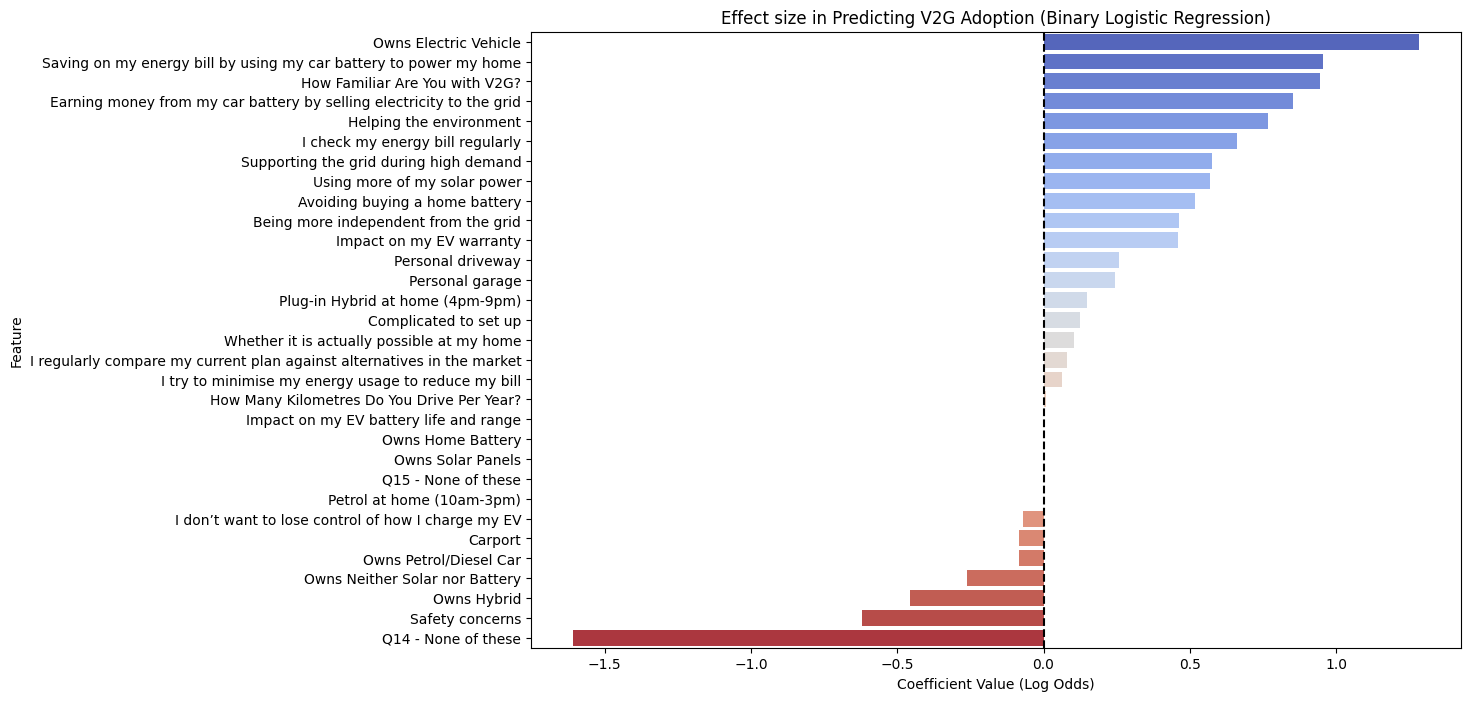

In [37]:
# Extract coefficients
coefs_binary = model_binary.coef_[0]  # Shape: (1, n_features), so take [0]

# Create DataFrame for visualization
coefs_binary_df = pd.DataFrame({'Feature': columns_of_interest_filtered, 'Coefficient': coefs_binary})
coefs_binary_df.sort_values(by="Coefficient", ascending=False, inplace=True)
coefs_binary_df["Feature"] = coefs_binary_df["Feature"].map(feature_label_map)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x="Coefficient", y="Feature", data=coefs_binary_df, palette="coolwarm")
plt.title("Effect size in Predicting V2G Adoption (Binary Logistic Regression)")
plt.xlabel("Coefficient Value (Log Odds)")
plt.ylabel("Feature")
plt.axvline(x=0, color='black', linestyle='--')  # Reference line for neutral impact
plt.show()

## 5.2. Odds Ratio

In [38]:
coefs_binary_df

,Feature,Coefficient
8,Owns Electric Vehicle,1.283097
14,Saving on my energy bill by using my car batte...,0.957358
0,How Familiar Are You with V2G?,0.945864
13,Earning money from my car battery by selling e...,0.851655
15,Helping the environment,0.765968
28,I check my energy bill regularly,0.660360
17,Supporting the grid during high demand,0.576704
16,Using more of my solar power,0.569627
19,Avoiding buying a home battery,0.518210
18,Being more independent from the grid,0.464196


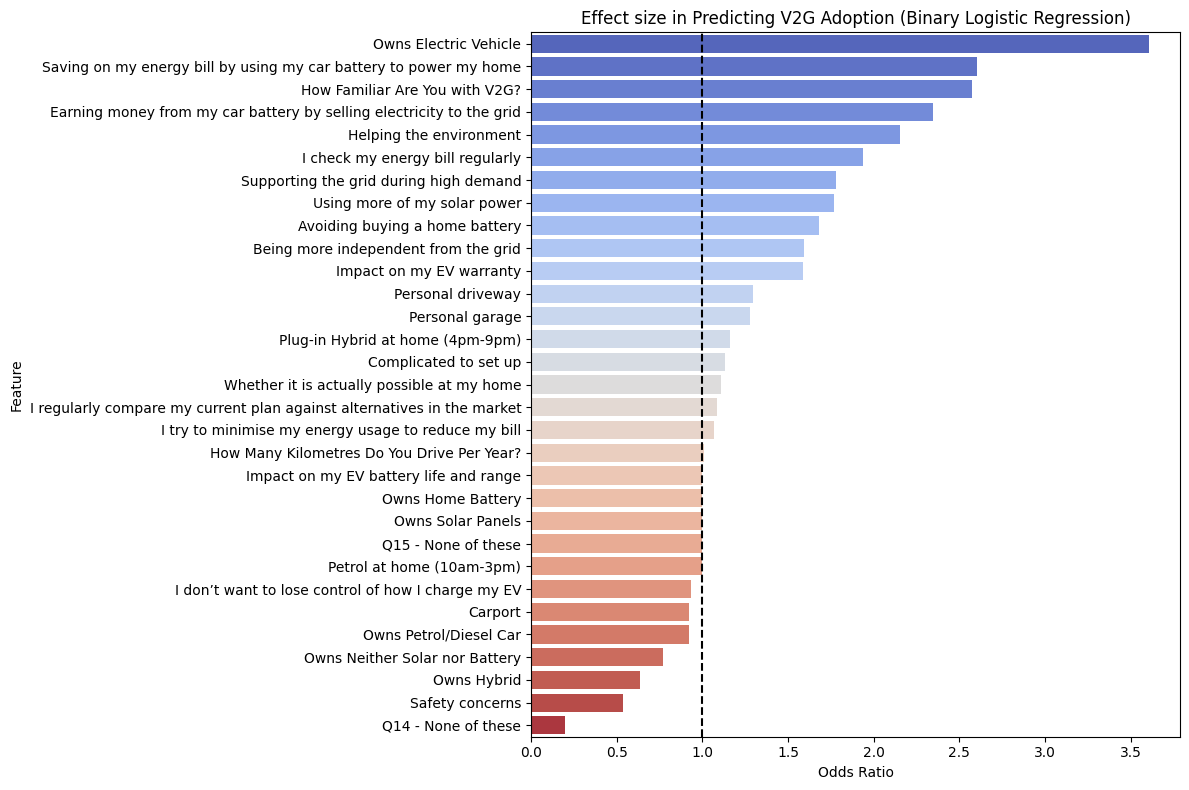

In [39]:
# 1. Compute Odds Ratio
coefs_binary_df["Odds Ratio"] = np.exp(coefs_binary_df["Coefficient"])

# 2. Sort by Odds Ratio if you prefer (so that the strongest effects appear at the top/bottom)
coefs_binary_df.sort_values(by="Odds Ratio", ascending=False, inplace=True)

# 3. Plot using Odds Ratio
plt.figure(figsize=(12, 8))
sns.barplot(x="Odds Ratio", y="Feature", data=coefs_binary_df, palette="coolwarm")

# 4. Add a vertical reference line at x=1 (since OR=1 means "no effect")
plt.axvline(x=1, color='black', linestyle='--')

# 5. Label and show
plt.title("Effect size in Predicting V2G Adoption (Binary Logistic Regression)")
plt.xlabel("Odds Ratio")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

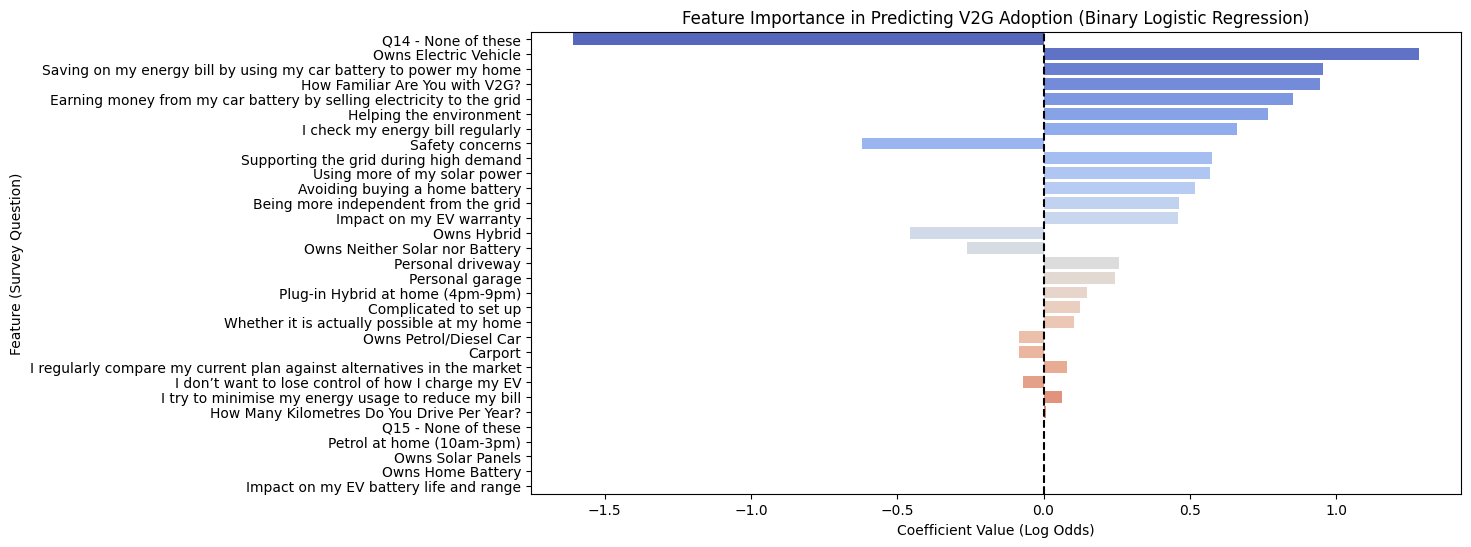

In [40]:
# Sort features by absolute coefficient magnitude for better visualization
coefs_binary_df["abs_coef"] = coefs_binary_df["Coefficient"].abs()
coefs_binary_df = coefs_binary_df.sort_values(by="abs_coef", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x="Coefficient", y="Feature", data=coefs_binary_df, palette="coolwarm")
plt.title("Feature Importance in Predicting V2G Adoption (Binary Logistic Regression)")
plt.xlabel("Coefficient Value (Log Odds)")
plt.ylabel("Feature (Survey Question)")
plt.axvline(x=0, color='black', linestyle='--')  # Reference line for neutral impact
plt.show()

In [41]:
# Predict on test data
y_pred_binary = model_binary.predict(X_test)

# Compute accuracy
accuracy_binary = accuracy_score(y_test, y_pred_binary)
print(f"Model Accuracy: {accuracy_binary:.2%}")

Model Accuracy: 79.34%


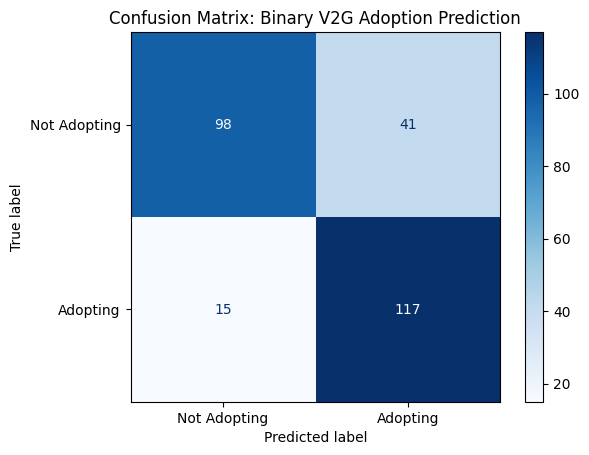

In [42]:
cm_binary = confusion_matrix(y_test, y_pred_binary, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm_binary, display_labels=["Not Adopting", "Adopting"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: Binary V2G Adoption Prediction")
plt.show()

In [43]:
df.loc[df["Q1_2"] == 0, q6a_ev] = 0  # Set EV charging times to 0 if they don't own an EV
df.loc[df["Q1_1"] == 0, q6a_petrol] = 0  # Set Petrol charging times to 0 if they don't own a Petrol car

In [44]:
valid_rows = df[significant_columns + [target_variable]].dropna().shape[0]
print(f"Valid rows: {valid_rows} / {df.shape[0]}")

Valid rows: 1358 / 1358


In [45]:
# Train model with binary logistic regression
model_binary, X_train, y_train, X_test, y_test = build_v2g_model_binary_from_df(
    df,  
    significant_columns,  # Keep same features
    target_variable,  
    TRANSFORMERS_q6a,  
    do_normalize=True,
    test_split_ratio=0.2
)

Unique values in y_train: (array([0, 1]), array([507, 577], dtype=int64))
Unique values in y_test: (array([0, 1]), array([139, 132], dtype=int64))
Train Accuracy: 81.92%
Test Accuracy: 79.34%


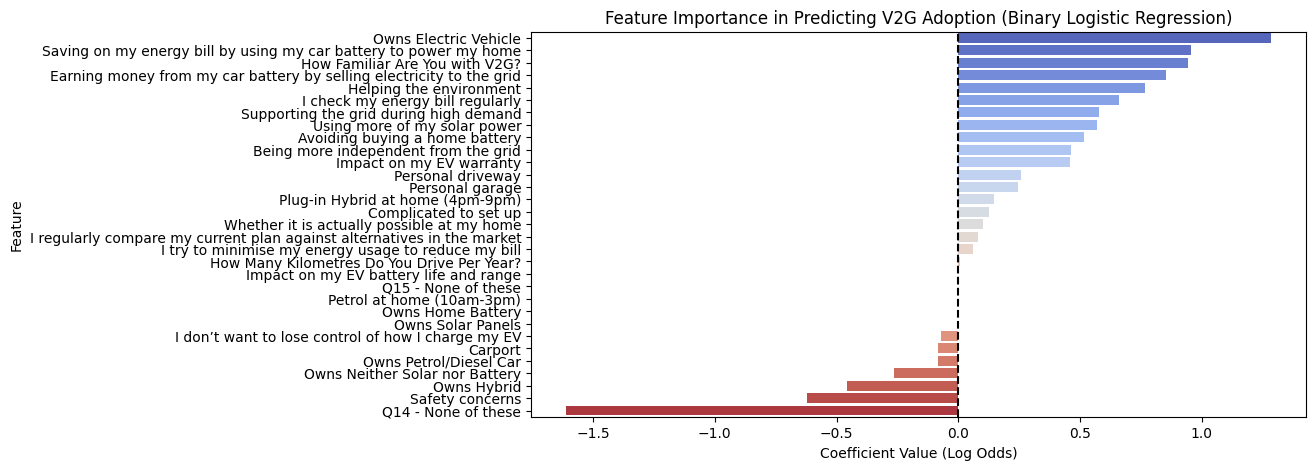

In [46]:
# Extract coefficients
coefs_binary = model_binary.coef_[0]  # Shape: (1, n_features), so take [0]

# Create DataFrame for visualization
coefs_binary_df = pd.DataFrame({'Feature': significant_columns, 'Coefficient': coefs_binary})
coefs_binary_df.sort_values(by="Coefficient", ascending=False, inplace=True)
coefs_binary_df["Feature"] = coefs_binary_df["Feature"].map(feature_label_map)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="Coefficient", y="Feature", data=coefs_binary_df, palette="coolwarm")
plt.title("Feature Importance in Predicting V2G Adoption (Binary Logistic Regression)")
plt.xlabel("Coefficient Value (Log Odds)")
plt.ylabel("Feature")
plt.axvline(x=0, color='black', linestyle='--')  # Reference line for neutral impact
plt.show()

In [ ]:
coefs_binary_df

# 6. Correlation matrix

In [ ]:
filtered_df

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Make a copy of the dataframe to transform
transformed_df = filtered_df.copy()

# Apply transformers to all columns in the dataframe
for col in transformed_df.columns:
    if col in TRANSFORMERS:  # Check if a transformer exists for the column
        transformed_df[col] = transformed_df[col].apply(TRANSFORMERS[col])

# Ensure numeric values (in case any errors occurred)
transformed_df = transformed_df.apply(pd.to_numeric, errors='coerce')

# Compute correlation matrix
corr_matrix = transformed_df.corr()

# Plot heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Transformed Features")
plt.show()
